## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [3]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_1199/2637987050.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

==> Looking for correlation in our data.

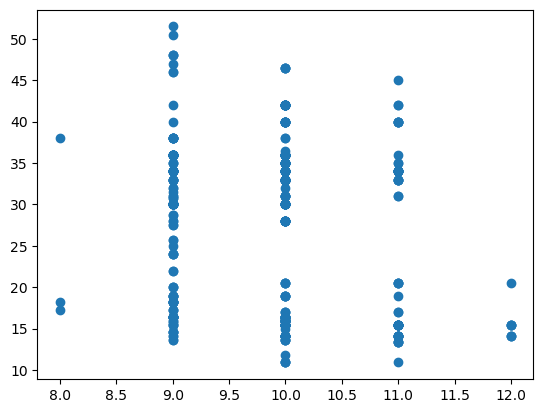

In [4]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

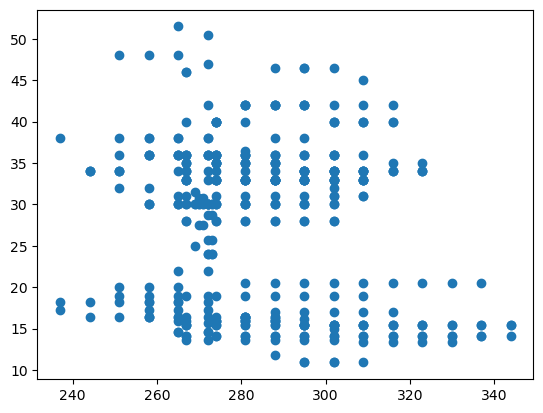

In [5]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

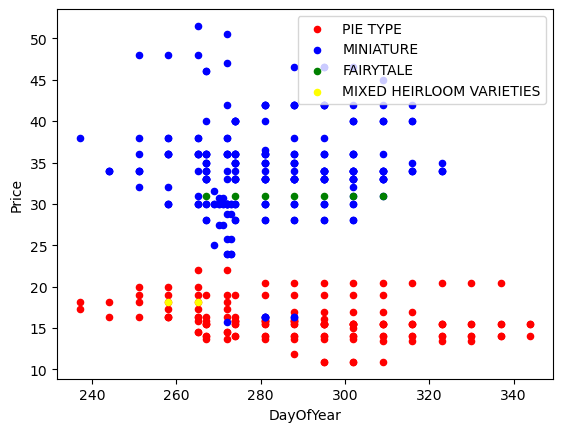

In [6]:
# Add the variety of the pumpkins
ax=None
colors = ['red', 'blue', 'green', 'yellow']
for var, color in zip(new_pumpkins['Variety'].unique(), colors):
    data = new_pumpkins[new_pumpkins['Variety'] == var]
    ax = data.plot.scatter('DayOfYear', 'Price', color=color, label=var, ax=ax)

In [7]:
# Show the correlation between the variety and the price
# Create a dictionary of the variety
varieties = new_pumpkins['Variety'].unique()
varieties = {variety: i for i, variety in enumerate(varieties)}
new_pumpkins['Variety'] = new_pumpkins['Variety'].map(varieties)

print(new_pumpkins['Variety'].corr(new_pumpkins['Price']))

0.7756380450625822


In [8]:
print(varieties)

{'PIE TYPE': 0, 'MINIATURE': 1, 'FAIRYTALE': 2, 'MIXED HEIRLOOM VARIETIES': 3}


Focus on the `pie type` pumpkins.

<Axes: xlabel='DayOfYear', ylabel='Price'>

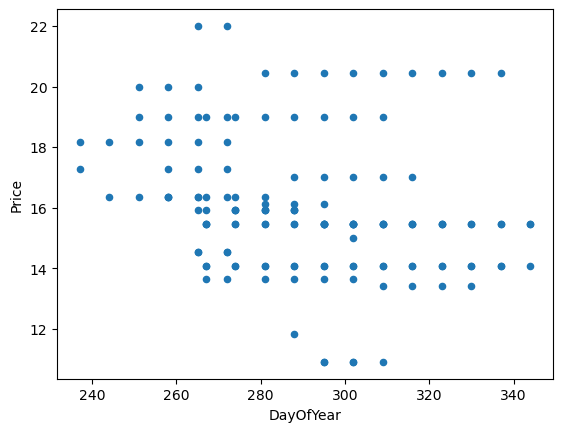

In [9]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety'] == 0]
pie_pumpkins.plot.scatter('DayOfYear', 'Price')

In [10]:
# clear missing values
new_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    int32  
 1   DayOfYear   144 non-null    int64  
 2   Variety     144 non-null    int64  
 3   City        144 non-null    object 
 4   Package     144 non-null    object 
 5   Low Price   144 non-null    float64
 6   High Price  144 non-null    float64
 7   Price       144 non-null    float64
dtypes: float64(3), int32(1), int64(2), object(2)
memory usage: 9.6+ KB


### Train a Linera Regression model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [12]:
# Separe the input to the target
X = pie_pumpkins['DayOfYear'].values.reshape(-1, 1)
y = pie_pumpkins['Price'].values

# Note that we had to perform reshape on the input data in order for the Linear 
# Regression package to understand it correctly. Linear Regression expects a 
# 2D-array as an input, where each row of the array corresponds to a vector of 
# input features. In our case, since we have only one input - we need an array 
# with shape N×1, where N is the dataset size.

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)

# Calculate the mean squared error
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3f} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.769 (17.2%)


The mean error of 2 points is not good. Let's check the determniation coefficient (that is way to low).

In [14]:
print('Determination score', lin_reg.score(X_train, y_train))

Determination score 0.04460606335028361


### Polynomial regression is a better fit for this data.

 A pipeline is a chain of estimators. In our case, we will create a pipeline that first adds polynomial features to our model, and then trains the regression:

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Include all the polynomial features up to the 2nd degree
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

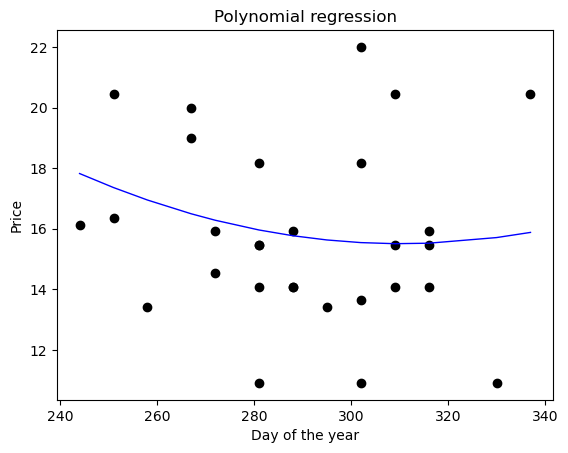

In [18]:
# plot the data
X_test.sort(axis=0)
y_pred = pipeline.predict(X_test)
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=1, label='Polynomial regression')
plt.xlabel('Day of the year')
plt.ylabel('Price')
plt.title('Polynomial regression')
plt.show()

### Encode the Variety

In [19]:
pd.get_dummies(new_pumpkins['Variety'])

,0,1,2,3
70,True,False,False,False
71,True,False,False,False
72,True,False,False,False
73,True,False,False,False
74,True,False,False,False
...,...,...,...,...
1738,False,True,False,False
1739,False,True,False,False
1740,False,True,False,False
1741,False,True,False,False


In [23]:
# Data preparation
pumpkins = pd.read_csv('../data/US-pumpkins.csv')
price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month

day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2


/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_1199/1348920829.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


In [ ]:

# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)